# Reduce dimensions
---
> 1. Load and prep data
> 2. Focus on prescriptions that make up a significant annual dollar volume per prescriber
> 3. Focus on states with highest exclusion rates


In [1]:
%reload_ext autoreload

# import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from multiprocessing import Pool
!pip install tqdm
from tqdm import tqdm_notebook
import itertools

# import own scripts
import sys
sys.path.insert(0, '/healthcare-fraud/src/')
import scripts as src

    100% |████████████████████████████████| 51kB 12.4MB/s ta 0:00:01
distributed 1.21.8 requires msgpack, which is not installed.
You are using pip version 10.0.1, however version 18.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
df = src.read_from_efs('df_trgt.csv')

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:472: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


df shape:  (94285120, 26)


In [3]:
src.print_info(df, 'df')
df.tail()

df pd.DataFrame shape: (94285120, 26)
df pd.DataFrame size: 19705.59 Mb


,npi,nppes_provider_last_org_name,nppes_provider_first_name,nppes_provider_city,nppes_provider_state,specialty_description,description_flag,drug_name,generic_name,bene_count,...,total_claim_count_ge65,ge65_suppress_flag,total_30_day_fill_count_ge65,total_day_supply_ge65,total_drug_cost_ge65,year,EXCLTYPE,EXCLDATE,REINDATE,label
94285115,1992999882,RUDZINSKI-WALTER,MARISSA,WILKES BARRE,PA,Physician Assistant,S,LAMOTRIGINE,LAMOTRIGINE,NaN,...,0.0,NaN,0.0,0.0,0.0,2016,NaN,NaN,NaN,False
94285116,1992999882,RUDZINSKI-WALTER,MARISSA,WILKES BARRE,PA,Physician Assistant,S,QUETIAPINE FUMARATE,QUETIAPINE FUMARATE,NaN,...,0.0,NaN,0.0,0.0,0.0,2016,NaN,NaN,NaN,False
94285117,1992999882,RUDZINSKI-WALTER,MARISSA,WILKES BARRE,PA,Physician Assistant,S,RISPERIDONE,RISPERIDONE,NaN,...,NaN,*,NaN,NaN,NaN,2016,NaN,NaN,NaN,False
94285118,1992999882,RUDZINSKI-WALTER,MARISSA,WILKES BARRE,PA,Physician Assistant,S,SERTRALINE HCL,SERTRALINE HCL,13.0,...,NaN,*,NaN,NaN,NaN,2016,NaN,NaN,NaN,False
94285119,1992999882,RUDZINSKI-WALTER,MARISSA,WILKES BARRE,PA,Physician Assistant,S,TRAZODONE HCL,TRAZODONE HCL,16.0,...,NaN,*,NaN,NaN,NaN,2016,NaN,NaN,NaN,False


In [4]:
df1 = df.groupby(['nppes_provider_state','npi','generic_name']).agg('sum').reset_index()\
                                        .sort_values(by=['npi','total_drug_cost'], ascending=[True, False]).reset_index(drop=True)

df1.drop(labels=['bene_count_ge65',
                 'total_claim_count_ge65',
                 'total_30_day_fill_count_ge65',
                 'total_day_supply_ge65',
                 'total_drug_cost_ge65',
                 'year','EXCLDATE','REINDATE'], axis=1, inplace=True)

df1.loc[df['label']!=0, 'label'] = True
df1.loc[df['label']==0, 'label'] = False

# replace zeros with 10
df1.loc[(df1['bene_count'] == 0), 'bene_count'] = 10
df1.loc[(df1['total_claim_count'] == 0), 'total_claim_count'] = 10

# add implicit features
df1['cost_per_bene'] = df1['total_drug_cost']/df1['bene_count']
df1['cost_per_claim'] = df1['total_drug_cost']/df1['total_claim_count']

In [5]:
src.print_info(df1, 'df1')
df1.tail()

df1 pd.DataFrame shape: (35567014, 11)
df1 pd.DataFrame size: 2880.93 Mb


,nppes_provider_state,npi,generic_name,bene_count,total_claim_count,total_30_day_fill_count,total_day_supply,total_drug_cost,label,cost_per_bene,cost_per_claim
35567009,PA,1992999882,SERTRALINE HCL,13.0,23,23.0,640,110.68,False,8.513846,4.812174
35567010,PA,1992999882,LAMOTRIGINE,10.0,16,16.0,367,108.87,False,10.887000,6.804375
35567011,PA,1992999882,CLONAZEPAM,11.0,13,13.0,317,70.51,False,6.410000,5.423846
35567012,PA,1992999882,CITALOPRAM HYDROBROMIDE,10.0,17,17.0,454,50.37,False,5.037000,2.962941
35567013,PA,1992999882,HYDROCHLOROTHIAZIDE,10.0,11,11.0,330,39.24,False,3.924000,3.567273


In [ ]:
# need to recreate code to produce df_final_vertical


In [147]:
def index_last_rows(npi):
    mask = df1['npi'] == npi
    df1.loc[mask, 'cost_proportion'] = df1['total_drug_cost'][mask]/sum(df1['total_drug_cost'][mask])
    return df1[mask][df1['cost_proportion'][mask]<0.005].index.tolist()

In [148]:
y = df1.pop('label')
X = df1

## Exclude extremely rare prescriptions
---
> It's reasonable to use `total_30_day_fill_count` and `total_30_day_fill_count_ge65`

In [149]:
generic_name_cnt = X.groupby('generic_name').agg('sum').reset_index()[['generic_name',
                                                                       'total_30_day_fill_count']]

generic_name_cnt['sum'] = generic_name_cnt['total_30_day_fill_count']
generic_name_cnt.sort_values(by='sum', ascending=False, inplace=True)
generic_name_cnt.reset_index(drop=True, inplace=True)
print('generic_name_cnt shape: ', generic_name_cnt.shape)
generic_name_cnt.head()

generic_name_cnt shape:  (951, 3)


,generic_name,total_30_day_fill_count,sum
0,LEVOTHYROXINE SODIUM,2.978697e+08,2.978697e+08
1,LISINOPRIL,2.635640e+08,2.635640e+08
2,ATORVASTATIN CALCIUM,2.511843e+08,2.511843e+08
3,AMLODIPINE BESYLATE,2.434446e+08,2.434446e+08
4,SIMVASTATIN,2.414213e+08,2.414213e+08


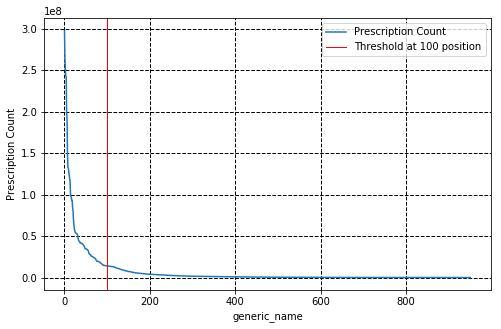

In [168]:
data = generic_name_cnt['sum']
threshold = 100
src.log_plot(data, threshold,'Prescription count `generic_name` in descending order', \
         'Prescription Count', 'generic_name', logx=False, logy=False, figsize=(8,5))
plt.show()

In [169]:
target_drugs = generic_name_cnt['generic_name'][:threshold]

# get indeces for target_drugs
def find_drug_index(drug):
    return X[X['generic_name']==drug].index.tolist()

In [170]:
print("Number of available CPU cores: ")
!cat /proc/cpuinfo | grep processor | wc -l

Number of available CPU cores: 
64


In [171]:
# find target indeces for target drugs using multiprocessing
processors = 64
if __name__ == '__main__':
    tasks = target_drugs
    function = find_drug_index
    with Pool(processes=processors)as p:
        results = list(tqdm_notebook(p.imap(function, tasks), total=len(tasks)))
        
trgt_idx = list(itertools.chain(*results))

In [173]:
X_drugs = X.iloc[trgt_idx].reset_index(drop=True)
print("X_drugs shape: ", X_drugs.shape)

y_drugs = y.iloc[trgt_idx].reset_index(drop=True)
print("y_drugs shape: ", y_drugs.shape)

X_drugs shape:  (20196011, 10)
y_drugs shape:  (20196011,)


In [174]:
X_drugs = X_drugs.reset_index(drop=True)
y_drugs = y_drugs.reset_index(drop=True)

In [175]:
X_drugs

,nppes_provider_state,npi,generic_name,bene_count,total_claim_count,total_30_day_fill_count,total_day_supply,total_drug_cost,cost_per_bene,cost_per_claim
0,TN,1003000282,LEVOTHYROXINE SODIUM,10.0,14,18.0,399,198.87,19.887000,14.205000
1,PA,1003000407,LEVOTHYROXINE SODIUM,31.0,243,243.0,3402,2180.19,70.328710,8.971975
2,FL,1003000522,LEVOTHYROXINE SODIUM,339.0,1321,3040.4,91196,31151.11,91.891180,23.581461
3,PA,1003000530,LEVOTHYROXINE SODIUM,202.0,1378,1886.5,56175,19163.23,94.867475,13.906553
4,FL,1003000720,LEVOTHYROXINE SODIUM,10.0,11,11.0,330,310.25,31.025000,28.204545
5,KY,1003000902,LEVOTHYROXINE SODIUM,125.0,630,1015.0,30368,11883.35,95.066800,18.862460
6,CA,1003001132,LEVOTHYROXINE SODIUM,10.0,13,37.0,1090,311.50,31.150000,23.961538
7,MI,1003001884,LEVOTHYROXINE SODIUM,253.0,674,1629.3,48845,13531.70,53.484980,20.076706
8,CA,1003002049,LEVOTHYROXINE SODIUM,69.0,445,942.6,28207,15475.45,224.281884,34.776292
9,MA,1003002312,LEVOTHYROXINE SODIUM,54.0,290,488.0,14640,4706.86,87.164074,16.230552


### **Label Data (y)**
---

## Focus on states with highest exclusion rates
---

In [176]:
# add label
X_drugs['exclusion'] = y_drugs

# count `exclusion by state`
exclusions_by_state = X_drugs[['nppes_provider_state','exclusion']].groupby('nppes_provider_state').agg('sum')\
                                                             .sort_values('exclusion', ascending=False).astype(int)

# count Medicare Part D `providers by state`
providers_by_state = X_drugs[['nppes_provider_state','npi']].groupby('nppes_provider_state').agg('count')\
                                                             .sort_values('npi', ascending=False).astype(int)

# join `exclusion by state` and `providers by state`
counts_by_state = providers_by_state.join(exclusions_by_state)

# calculate `exclusion ratio`
counts_by_state['exclusion_ratio'] = counts_by_state['exclusion']/counts_by_state['npi']
counts_by_state.sort_values('exclusion_ratio', ascending=False, inplace=True)
counts_by_state.head()

,npi,exclusion,exclusion_ratio
nppes_provider_state,,,
AE,567,9,0.015873
ID,107352,464,0.004322
DC,43009,154,0.003581
SD,64808,197,0.003040
IA,238422,706,0.002961


In [177]:
# Build `state_ratio_df` with cummulatives
state_ratio_df = pd.DataFrame()
state_ratio_df['cumm_provider_cnt'] = counts_by_state['npi'].cumsum()
state_ratio_df['cumm_exclusion_cnt'] = counts_by_state['exclusion'].cumsum()
state_ratio_df['exclusion_ratio'] = state_ratio_df['cumm_exclusion_cnt']/state_ratio_df['cumm_provider_cnt']

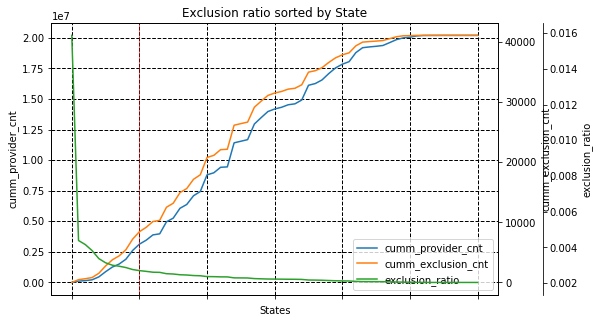

In [181]:
# Plot sorted cumulative chart by Exclusion Ratio
threshold_value=10
src.plot_multi(state_ratio_df, threshold_value, 'States', figsize=(8,5), title='Exclusion ratio sorted by State')
plt.show()

In [183]:
target_states = state_ratio_df.index[:threshold_value].tolist()
print('Top states by exclusion ratio: ', target_states)

Top states by exclusion ratio:  ['AE', 'ID', 'DC', 'SD', 'IA', 'MO', 'MN', 'CT', 'AZ', 'NC']


In [186]:
# get indeces for target_drugs
def find_state_index(state):
    return X_drugs[X_drugs['nppes_provider_state']==state].index.tolist()

In [187]:
# find target indeces for target states using multiprocessing
processors = 64
if __name__ == '__main__':
    tasks = target_states
    function = find_state_index
    with Pool(processes=processors)as p:
        results = list(tqdm_notebook(p.imap(function, tasks), total=len(tasks)))
        
trgt_idx = list(itertools.chain(*results))

In [189]:
# reduce data sets by top states
df_id_reduced = X_drugs.iloc[trgt_idx].reset_index(drop=True)
X_reduced = X_drugs.iloc[trgt_idx].reset_index(drop=True)
y_reduced = y_drugs.iloc[trgt_idx].reset_index(drop=True)

In [190]:
# Remove 'exclusion' from df_id
df_id_reduced.drop('exclusion', axis=1, inplace=True)

## Results:
---

### Reduced Identification Data (df_id)
> for consistancy remove `exclusion` column as a separate `label` data

In [191]:
print('df_id_reduced shape: ', df_id_reduced.shape)
df_id_reduced.head()

df_id_reduced shape:  (2614738, 10)


,nppes_provider_state,npi,generic_name,bene_count,total_claim_count,total_30_day_fill_count,total_day_supply,total_drug_cost,cost_per_bene,cost_per_claim
0,AE,1083814099,LEVOTHYROXINE SODIUM,30.0,40,94.0,2818,607.93,20.264333,15.198250
1,AE,1083924617,LEVOTHYROXINE SODIUM,95.0,774,925.8,27229,15603.77,164.250211,20.159910
2,AE,1093867137,LEVOTHYROXINE SODIUM,48.0,189,495.0,14850,6604.84,137.600833,34.946243
3,AE,1184932204,LEVOTHYROXINE SODIUM,20.0,37,82.0,2440,905.01,45.250500,24.459730
4,AE,1255694022,LEVOTHYROXINE SODIUM,10.0,36,38.0,1128,571.02,57.102000,15.861667


#### Reduced Feature Matrix (X)
---

In [194]:
print('X_reduced shape: ', X_reduced.shape)
X_reduced.head()

X_reduced shape:  (2614738, 11)


,nppes_provider_state,npi,generic_name,bene_count,total_claim_count,total_30_day_fill_count,total_day_supply,total_drug_cost,cost_per_bene,cost_per_claim,exclusion
0,AE,1083814099,LEVOTHYROXINE SODIUM,30.0,40,94.0,2818,607.93,20.264333,15.198250,False
1,AE,1083924617,LEVOTHYROXINE SODIUM,95.0,774,925.8,27229,15603.77,164.250211,20.159910,False
2,AE,1093867137,LEVOTHYROXINE SODIUM,48.0,189,495.0,14850,6604.84,137.600833,34.946243,False
3,AE,1184932204,LEVOTHYROXINE SODIUM,20.0,37,82.0,2440,905.01,45.250500,24.459730,False
4,AE,1255694022,LEVOTHYROXINE SODIUM,10.0,36,38.0,1128,571.02,57.102000,15.861667,False


#### Reduced Label Data `y_reduced`
---

In [196]:
print('y_reduced shape: ', y_reduced.shape)
sum(y_reduced)

y_reduced shape:  (2614738,)


7206

### Save to efs

In [197]:
src.save_to_efs(y_reduced,'y_reduced.csv')
src.save_to_efs(X_reduced,'X_reduced.csv')
src.save_to_efs(X_reduced, 'df_id_reduced.csv')